In [28]:
import pandas as pd
conditions = pd.read_csv('conditions.csv')
abundance_data = pd.read_csv('abundance_data.csv')

The controls (AB- and AB+) from Milani et al. (2016) were removed because they were hospitalized individuals, whether treated with antibiotics or not, and the diarrheaCDI- group from Duan et al. (2020) was excluded due to the presence of diarrhea.

In [29]:


values_to_remove = [ 'AB-', 'AB+', 'diarrheaCDI-']
mask = ~conditions['Condition'].isin(values_to_remove)
conditions = conditions[mask]
complete_df_before_pivot = pd.merge(abundance_data, conditions, on='Individual')
complete_df = complete_df_before_pivot.pivot(index=["Individual", "Condition"], columns="Gene", values="TotalNormalizedReads")
complete_df = complete_df.reset_index()


In [30]:
print("Samples distribution:\n", conditions['Condition'].value_counts())


Samples distribution:
 Condition
CD         674
Control    482
UC         435
CDI+        59
Name: count, dtype: int64


In [31]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multitest import multipletests

# List of conditions to compare against Control
comparisons = ["UC", "CDI+", "CD"]

# List of genes (all columns from the 3rd onward)
genes = complete_df.columns[2:]

# Create a dictionary to store p-values
p_values = {cond: [] for cond in comparisons}

# Perform Mann-Whitney U test for each condition vs. Control for each gene
for gene in genes:
    for cond in comparisons:
        group1 = complete_df[complete_df["Condition"] == cond][gene]
        group2 = complete_df[complete_df["Condition"] == "Control"][gene]

        # Ensure there is at least one value in each group before testing
        if len(group1) > 0 and len(group2) > 0:
            stat, p = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        else:
            p = np.nan  # Return NaN if there isn't enough data

        p_values[cond].append(p)

# Create a DataFrame with the p-values for each comparison
df_pvals = pd.DataFrame(p_values, index=genes)

# Apply multiple testing correction (FDR - Benjamini-Hochberg)
df_pvals_corrected = df_pvals.apply(lambda col: multipletests(col, method="fdr_bh")[1])

# Round the p-values to 4 decimal places
df_pvals_corrected = df_pvals_corrected.round(4)

# Create boolean columns indicating statistical significance (p < 0.01)
df_significant = df_pvals_corrected < 0.01

# Concatenate the corrected p-values and the significance flags
df_final = pd.concat([df_pvals_corrected, df_significant.add_suffix("_sig")], axis=1)

# Replace dot with comma in p-values (Brazilian number format)
df_final = df_final.astype(str).apply(lambda col: col.str.replace(".", ","))

# Display the result
print(df_final)

# Save to TSV file with tab as separator
df_final.to_csv("mann_whitney_results_with_significance.tsv", sep="\t", index=True)


           UC    CDI+      CD UC_sig CDI+_sig CD_sig
Gene                                                
KpsC   0,1401     0,0  0,2906  False     True  False
KpsD   0,0609     0,0     1,0  False     True  False
KpsE   0,9446     0,0  0,2335  False     True  False
KpsF   0,2591     0,0  0,2185  False     True  False
KpsS   0,3281     0,0  0,0147  False     True  False
KpsU   0,3124  0,6562  0,5275  False    False  False
Lic3A  0,9446     0,0  0,8181  False     True  False
Lic3B  0,9446     0,0  0,0307  False     True  False
Lst       1,0     1,0     1,0  False    False  False
NagA   0,7278  0,0137  0,0011  False    False   True
NagB   0,2591     0,0  0,0769  False     True  False
NanA   0,0005     0,0  0,0292   True     True  False
NanC   0,8751     0,0  0,0009  False     True   True
NanE   0,9446     0,0  0,8181  False     True  False
NanK   0,1401     0,0   0,441  False     True  False
NeuA   0,1401     0,0  0,3195  False     True  False
NeuB   0,1401  0,0021  0,0307  False     True 

In [32]:
from scipy.stats import kruskal
import pandas as pd
import numpy as np

# Example DataFrame (use your actual dataset)
data = complete_df

# Identify gene columns explicitly, excluding non-gene columns
genes = data.columns.difference(["Individual", "Condition"])

kruskal_results = {}

# Perform Kruskal-Wallis test for each gene
for gene in genes:
    # Group data by condition and drop NaN values
    groups = [
        data[data["Condition"] == cond][gene].dropna()
        for cond in data["Condition"].unique()
    ]

    # Skip the test if all groups have identical values
    if all(group.nunique() <= 1 for group in groups):
        print(f"Gene {gene} has all identical values, skipping the test.")
        continue

    # Perform Kruskal-Wallis test
    kruskal_results[gene] = kruskal(*groups)

# Extract p-values and test statistics into a DataFrame
p_values = pd.DataFrame({
    "Gene": list(kruskal_results.keys()),
    "H-statistic": [result.statistic for result in kruskal_results.values()],
    "p-value": [result.pvalue for result in kruskal_results.values()],
})

# FDR adjustment using the Benjamini-Hochberg procedure
p_values = p_values.sort_values("p-value").reset_index(drop=True)
p_values["Rank"] = p_values.index + 1
p_values["FDR-adjusted p-value"] = p_values["p-value"] * len(p_values) / p_values["Rank"]
p_values["Significant"] = p_values["FDR-adjusted p-value"] < 0.01

# Display the results
p_values


Gene Lst has all identical values, skipping the test.


,Gene,H-statistic,p-value,Rank,FDR-adjusted p-value,Significant
0,NanC,156.198862,1.211661e-33,1,3.392652e-32,True
1,NanK,135.727610,3.151834e-29,2,4.412567e-28,True
2,NanE,129.568181,6.700853e-28,3,6.254129e-27,True
3,KpsD,119.224753,1.133431e-25,4,7.934014e-25,True
4,KpsC,117.488119,2.681431e-25,5,1.501601e-24,True
5,SatD,113.695752,1.757373e-24,6,8.201076e-24,True
6,KpsE,111.295452,5.774698e-24,7,2.309879e-23,True
7,SatC,110.100541,1.043994e-23,8,3.653981e-23,True
8,KpsS,105.967471,8.091411e-23,9,2.517328e-22,True
9,NeuD,98.820904,2.786170e-21,10,7.801277e-21,True


Gene Lst has all identical values, skipping the test.


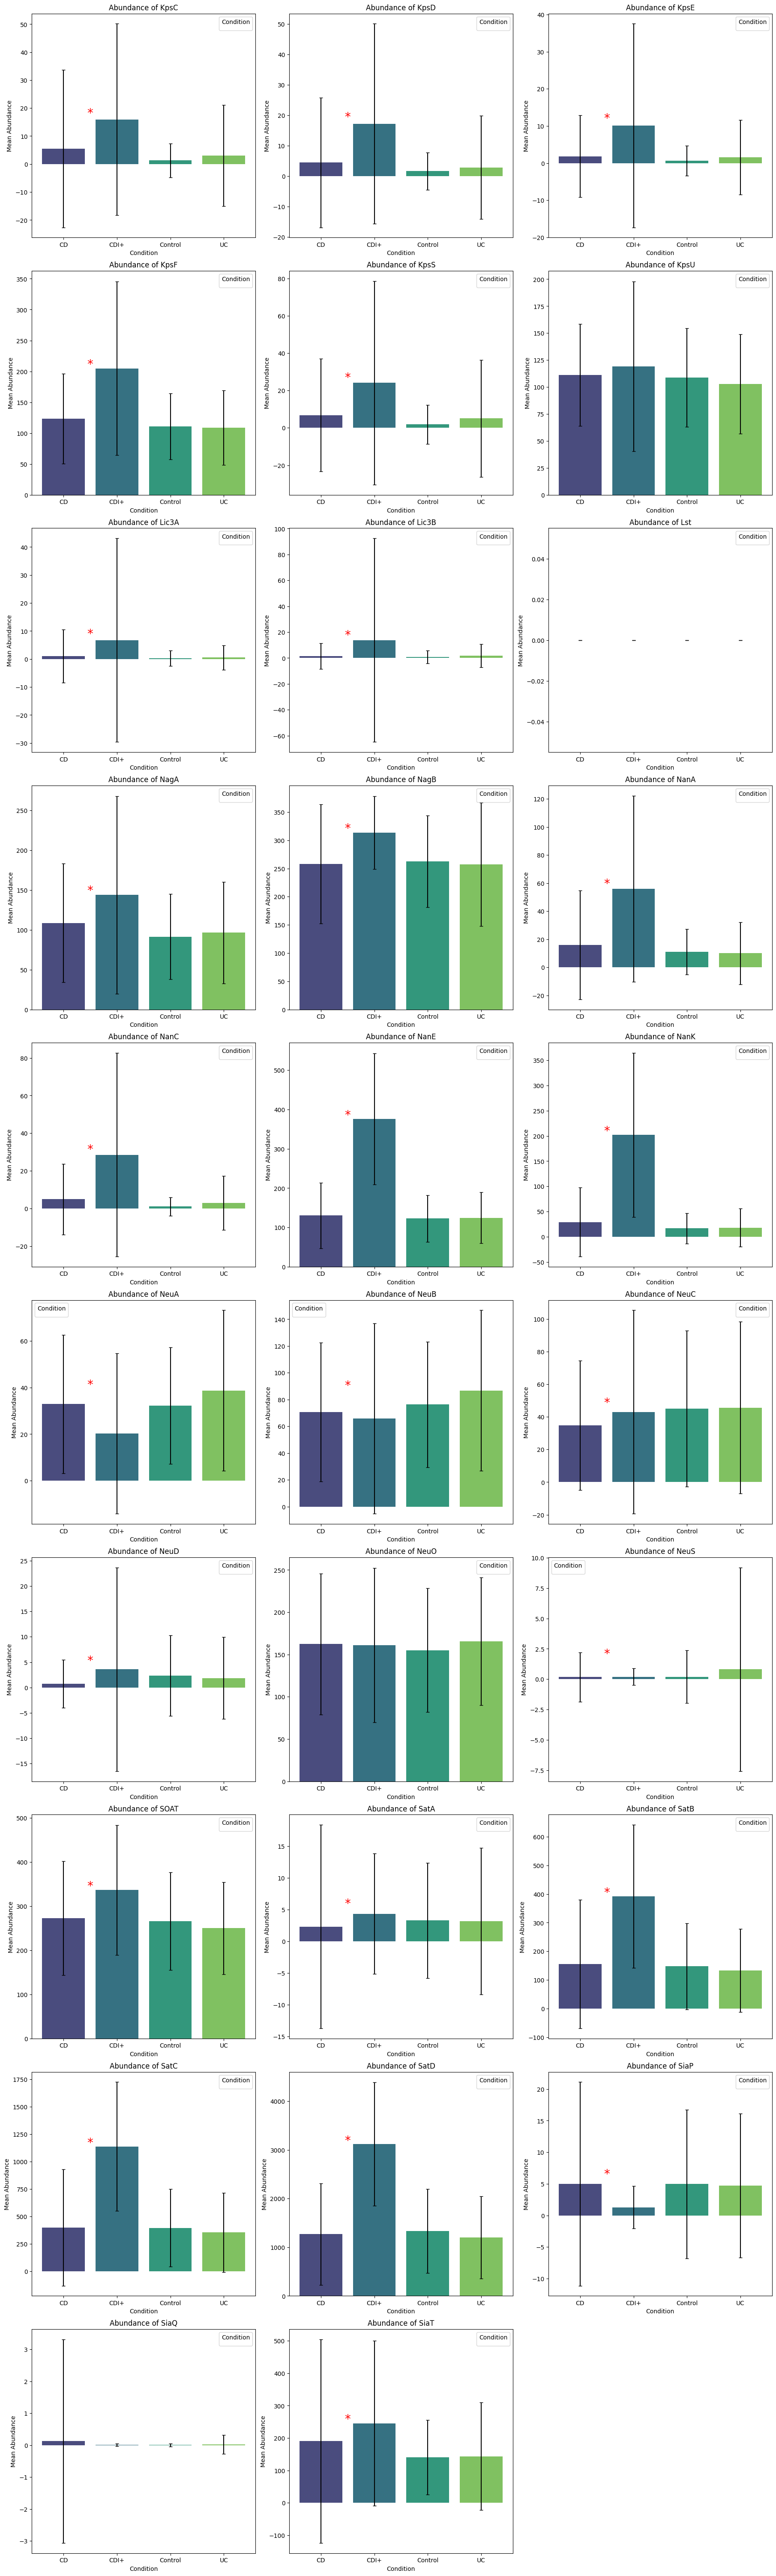

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset (replace with your actual merged_result DataFrame)
data = complete_df
# Identify gene columns by excluding metadata columns
genes = data.columns.difference(["Individual", "Condition"])

# Convert gene columns to numeric (to handle any non-numeric values gracefully)
data[genes] = data[genes].apply(pd.to_numeric, errors="coerce")

# Calculate mean, standard deviation, and sample count for each gene grouped by condition
summary_stats = (
    data.melt(id_vars=["Condition"], value_vars=genes, var_name="Gene", value_name="Abundance")  # Transform to long format
    .groupby(["Condition", "Gene"])["Abundance"]
    .agg(["mean", "std", "count"])  # Calculate mean, std, and count
    .reset_index()
)

# Add 95% confidence intervals (CI = 1.96 * std / sqrt(count))
summary_stats["ci_95"] = 1.96 * (summary_stats["std"] / np.sqrt(summary_stats["count"]))

# Perform the Kruskal-Wallis test for each gene
kruskal_results = {}
for gene in genes:
    # Create groups for the test, one group per condition
    groups = [data[data["Condition"] == cond][gene].dropna() for cond in data["Condition"].unique()]

    # Skip the test if all groups have identical values
    if all(group.nunique() <= 1 for group in groups):
        print(f"Gene {gene} has all identical values, skipping the test.")
        continue

    # Perform the test and store results
    kruskal_results[gene] = kruskal(*groups)

# Create a DataFrame for p-values and test statistics
p_values = pd.DataFrame({
    "Gene": list(kruskal_results.keys()),
    "H-statistic": [result.statistic for result in kruskal_results.values()],
    "p-value": [result.pvalue for result in kruskal_results.values()],
})

# Adjust p-values using the Benjamini-Hochberg (FDR) method
p_values = p_values.sort_values("p-value").reset_index(drop=True)
p_values["Rank"] = p_values.index + 1
p_values["FDR-adjusted p-value"] = p_values["p-value"] * len(p_values) / p_values["Rank"]
p_values["Significant"] = p_values["FDR-adjusted p-value"] < 0.01
p_values["Significant_star"] = np.where(p_values["Significant"], "*", "")  # Add a star for significant genes

# Merge significance information into the summary statistics for annotation
summary_stats = summary_stats.merge(
    p_values[["Gene", "Significant_star"]],
    on="Gene",
    how="left"
)

# Plot barplots for each gene, showing mean abundance, standard deviation, and significance
num_genes = len(genes)  # Total number of genes
rows = int(np.ceil(num_genes / 3))  # Arrange plots in a grid with 3 columns
fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 6), constrained_layout=True)

# Flatten axes to iterate over them (useful when rows > 1)
axes = axes.flatten()

# Iterate through genes and plot barplots
for idx, gene in enumerate(genes):
    sns.barplot(
      data=summary_stats[summary_stats["Gene"] == gene],
      x="Condition",
      y="mean",
      hue="Condition",
      errorbar=None,
      palette="viridis",
      ax=axes[idx],
      legend=False
)
    # Add error bars for standard deviation
    for condition_idx, row in summary_stats[summary_stats["Gene"] == gene].iterrows():
        axes[idx].errorbar(
            x=row["Condition"],
            y=row["mean"],
            yerr=row["std"],
            fmt="none",
            c="black",
            capsize=3,
        )

    # Add asterisks for significant genes
    significant_star = summary_stats.loc[summary_stats["Gene"] == gene, "Significant_star"].iloc[0]
    if significant_star == "*":
        axes[idx].text(
            0.5, max(summary_stats[summary_stats["Gene"] == gene]["mean"]) + 1,  # Position above bars
            "*", fontsize=20, color="red", ha="center"
        )

    # Set titles and labels
    axes[idx].set_title(f"Abundance of {gene}")
    axes[idx].set_ylabel("Mean Abundance")
    axes[idx].set_xlabel("Condition")
    axes[idx].legend(title="Condition")

# Remove any unused subplots
for idx in range(len(genes), len(axes)):
    fig.delaxes(axes[idx])

# Show the final figure
plt.show()

In [34]:
import pandas as pd
import numpy as np

# Load your dataset (replace merged_result with your actual DataFrame)
data = complete_df

# Identify gene columns by excluding metadata columns
genes = data.columns.difference(["Individual", "Condition"])

# Convert the gene columns to numeric values (handle invalid entries as NaN)
data[genes] = data[genes].apply(pd.to_numeric, errors="coerce")

# Group by "condition" and calculate mean, median, and standard deviation for each gene
summary_table = (
    data.melt(id_vars=["Condition"], value_vars=genes, var_name="Gene", value_name="Abundance")  # Transform to long format
    .groupby(["Condition", "Gene"])  # Group by condition and gene
    .agg(
        mean_abundance=("Abundance", "mean"),  # Calculate mean
        median_abundance=("Abundance", "median"),  # Calculate median
        std_abundance=("Abundance", "std")  # Calculate standard deviation
    )
    .reset_index()  # Flatten the grouped DataFrame
)
pd.set_option('display.max_rows', None)
# Display the resulting summary table
print(summary_table)

# Optionally save the table to a CSV file for further analysis
summary_table.to_csv("gene_abundance_summary.csv", index=False)



    Condition   Gene  mean_abundance  median_abundance  std_abundance
0          CD   KpsC        5.503961             0.000      28.155489
1          CD   KpsD        4.433027             0.000      21.305079
2          CD   KpsE        1.823145             0.000      11.034301
3          CD   KpsF      123.445979           110.810      72.605096
4          CD   KpsS        6.738872             0.000      30.154515
5          CD   KpsU      111.211677           114.155      47.369967
6          CD  Lic3A        1.045312             0.000       9.507932
7          CD  Lic3B        1.366068             0.000       9.913587
8          CD    Lst        0.000000             0.000       0.000000
9          CD   NagA      108.569436           105.175      74.504167
10         CD   NagB      257.958724           239.330     105.845932
11         CD   NanA       16.028709             3.450      38.838335
12         CD   NanC        4.925519             0.000      18.784984
13         CD   NanE

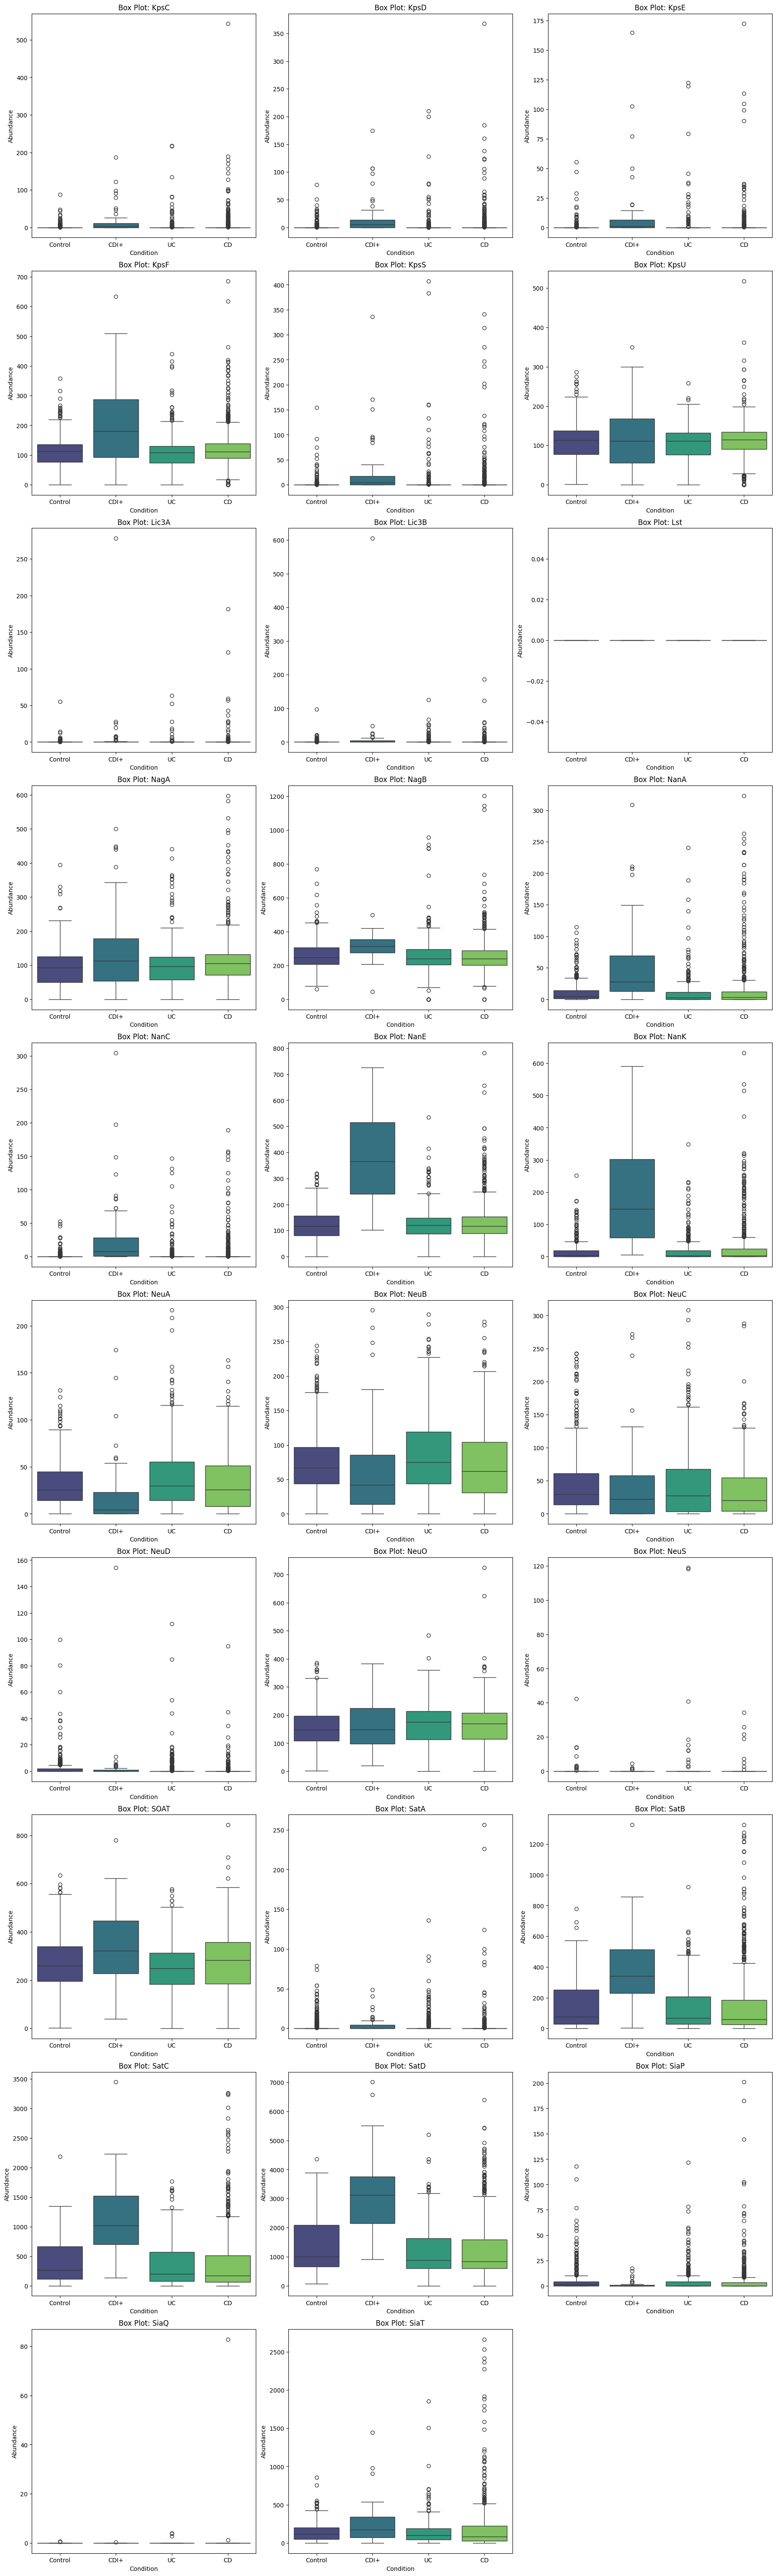

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Identify gene columns (exclude metadata columns)
genes = data.columns.difference(["Individual", "Condition"])

# Convert gene columns to numeric and drop rows with invalid (NaN) values
data[genes] = data[genes].apply(pd.to_numeric, errors="coerce")
data = data.dropna(subset=genes)

# Melt the DataFrame to a long format for plotting
plot_data = data.melt(id_vars=["Condition"], value_vars=genes, var_name="Gene", value_name="Abundance")

# Create a figure with subplots for each gene
num_genes = len(genes)
rows = int(np.ceil(num_genes / 3))  # Calculate number of rows (3 plots per row)
fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 6), constrained_layout=True)  # Adjust layout
axes = axes.flatten()  # Flatten axes for easier iteration

# Generate a box plot for each gene
for idx, gene in enumerate(genes):
    sns.boxplot(
      data=plot_data[plot_data["Gene"] == gene],
      y="Abundance",
      x="Condition",
      hue="Condition",
      palette="viridis",
      ax=axes[idx],
      legend=False
)
    # Customize the subplot with titles and labels
    axes[idx].set_title(f"Box Plot: {gene}")
    axes[idx].set_xlabel("Condition")
    axes[idx].set_ylabel("Abundance")

# Remove unused axes if the number of genes is not a multiple of 3
for idx in range(len(genes), len(axes)):
    fig.delaxes(axes[idx])

# Display the figure
plt.show()


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
dfx = complete_df.drop(['Condition', 'Individual'], axis=1)
dfy = complete_df['Condition']
dfx_train, dfx_test, dfy_train, dfy_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)


In [37]:
print("Trainning distribution:\n", dfy_train.value_counts())
print("Test distribution:\n", dfy_test.value_counts())

Trainning distribution:
 Condition
CD         550
Control    379
UC         347
CDI+        44
Name: count, dtype: int64
Test distribution:
 Condition
CD         124
Control    103
UC          88
CDI+        15
Name: count, dtype: int64


In [38]:
SVC_model = SVC(class_weight='balanced')
SVC_model.fit(dfx_train, dfy_train)
ypredSVC = SVC_model.predict(dfx_test)
accuracy_score(dfy_test, ypredSVC)

0.41818181818181815

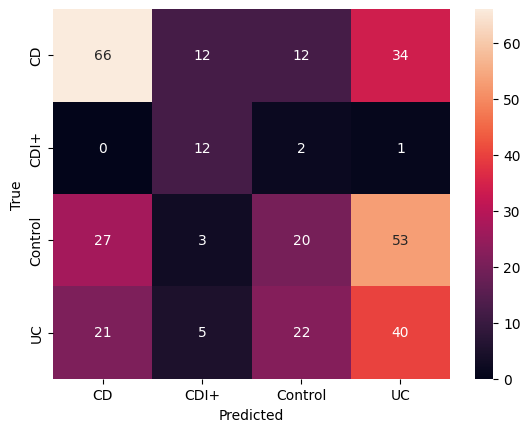

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(dfy_test,ypredSVC)
# Obter os nomes das classes
class_names = sorted(dfy_test.unique())  # Para garantir que as classes estão ordenadas corretamente

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [40]:
from sklearn.ensemble import RandomForestClassifier  # For classification

# Create the model:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # For classification

# Train the model:
model.fit(dfx_train, dfy_train)
ypred = model.predict(dfx_test)
accuracy_score(dfy_test, ypred)

0.6393939393939394

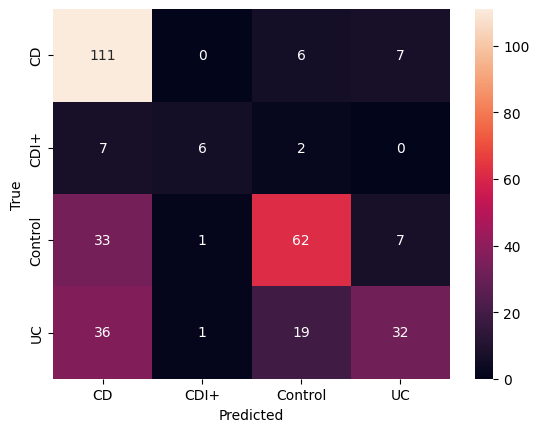

In [41]:
# Calculate the confusion matrix
cm = confusion_matrix(dfy_test,ypred)
# Obter os nomes das classes
class_names = sorted(dfy_test.unique())  # Para garantir que as classes estão ordenadas corretamente

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dfy_train_encoded = label_encoder.fit_transform(dfy_train)
dfy_test_encoded = label_encoder.transform(dfy_test)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, learning_rate=0.1 )
xgb_model.fit(dfx_train, dfy_train_encoded)
ypred_xgb = xgb_model.predict(dfx_test)
accuracy_score(dfy_test_encoded, ypred_xgb)


0.6393939393939394

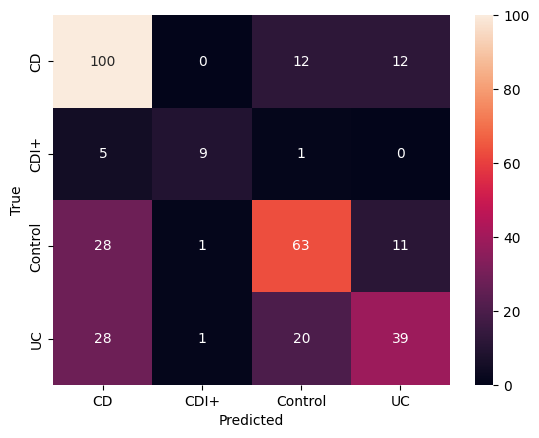

In [43]:
# Calculate the confusion matrix
cm = confusion_matrix(dfy_test_encoded,ypred_xgb)
# Obter os nomes das classes
class_names = sorted(dfy_test.unique())  # Para garantir que as classes estão ordenadas corretamente

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

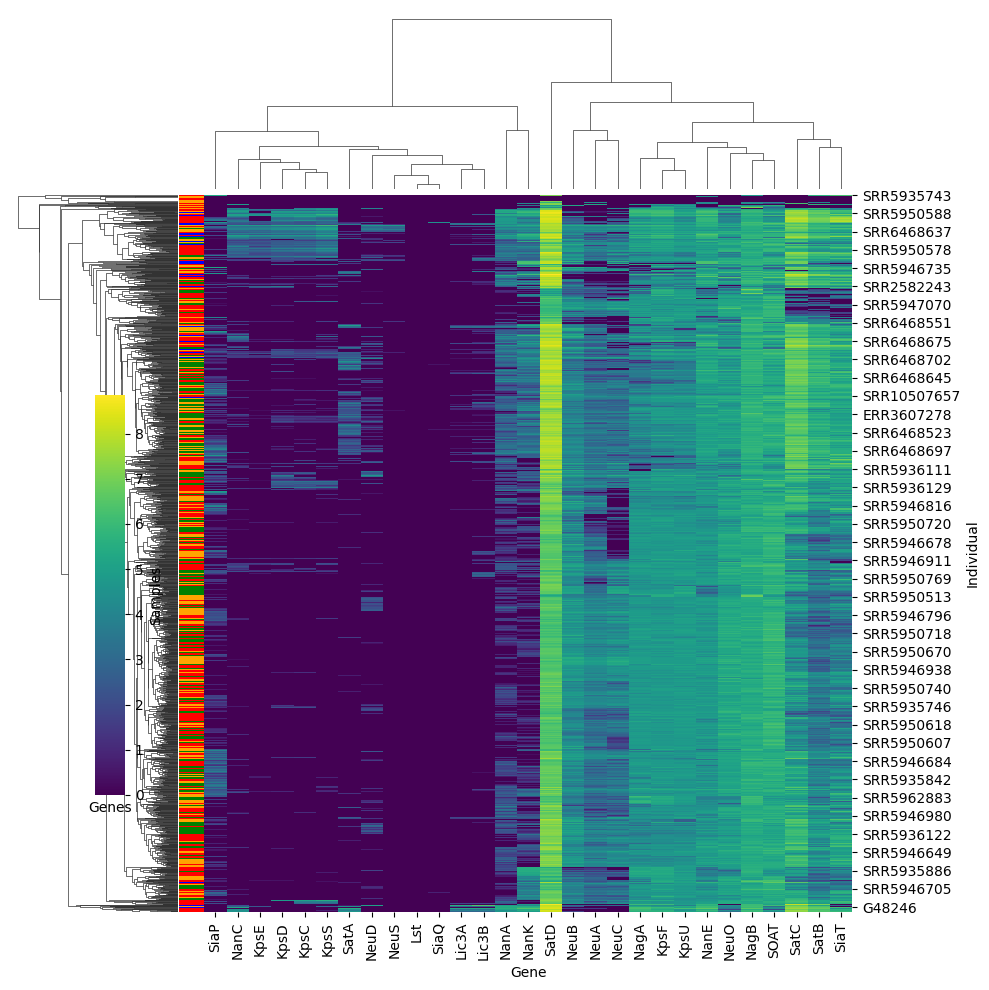

Clustermap saved as clustermap_colab.png


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def create_clustermap_colab(dataframe, output_image, normalization="log"):
    """
    Creates a clustermap based on gene abundance data and sample conditions.

    Args:
        dataframe (pd.DataFrame): DataFrame with presence/absence or abundance data.
        output_image (str): File name to save the generated image.
        normalization (str): Type of normalization ("log", "zscore", "minmax", or None).
    """
    # Set the first column as the index (sample name)
    dataframe = dataframe.set_index(dataframe.columns[0])

    # Filter only valid conditions
    valid_conditions = ['Control', 'UC', 'CD', 'CDI+']
    filtered_df = dataframe[dataframe['Condition'].isin(valid_conditions)]

    # Separate the 'Condition' column and extract the data (genes)
    conditions = filtered_df['Condition']
    df_data = filtered_df.drop(columns=['Condition'])

    # Apply normalization to the data
    if normalization == "log":
        df_data = np.log1p(df_data)  # log(1 + x) to avoid log(0)
    elif normalization == "zscore":
        scaler = StandardScaler()
        df_data[:] = scaler.fit_transform(df_data)  # Normalize to mean 0 and standard deviation 1
    elif normalization == "minmax":
        scaler = MinMaxScaler()
        df_data[:] = scaler.fit_transform(df_data)  # Normalize to values between 0 and 1

    # Define colors for each condition
    conditions_colors = {'Control': 'green', 'UC': 'orange', 'CD': 'red', 'CDI+': 'blue'}
    row_colors = [conditions_colors.get(cond, 'grey') for cond in conditions]

    # Create the clustermap
    plt.figure(figsize=(12, 10))
    g = sns.clustermap(df_data, cmap="viridis", linewidths=0.0, annot=False, fmt="d",
                       method='average', metric='euclidean',
                       row_colors=row_colors, cbar_pos=(0.1, 0.2, 0.03, 0.4))

    # Add title and labels
    plt.xlabel('Genes')
    plt.ylabel('Samples')

    # Save the clustermap as an image
    g.savefig(output_image, format='png', dpi=300)
    plt.show()

    print(f"Clustermap saved as {output_image}")

# Example usage in Google Colab with logarithmic transformation
output_image = 'clustermap_colab.png'
create_clustermap_colab(complete_df, output_image, normalization="log")


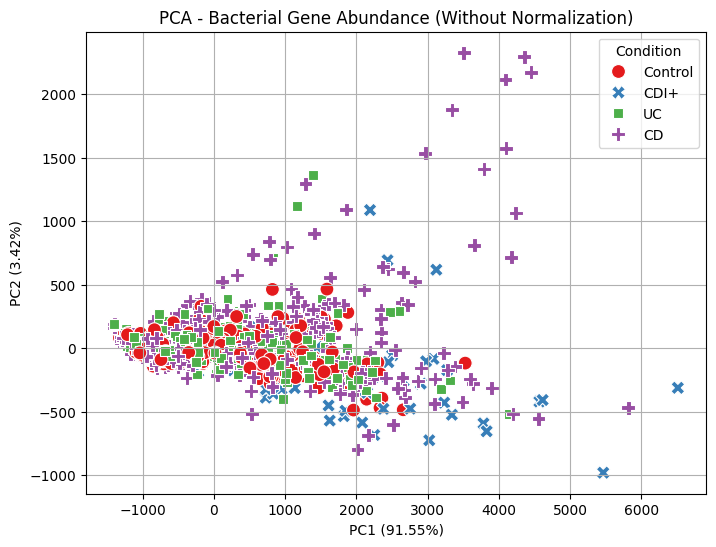

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 📌 1. Load the data
df = complete_df.copy()

# 📌 2. Separate metadata (sample and condition)
samples = df["Individual"]
conditions = df["Condition"]  # For coloring the plot
df = df.drop(columns=["Individual", "Condition"])  # Keep only gene columns

# 📌 3. Apply PCA directly to raw data without normalization
pca = PCA(n_components=2)  # Reduce to 2 principal components
pca_result = pca.fit_transform(df)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
pca_df["Individual"] = samples
pca_df["Condition"] = conditions

# 📌 4. Create PCA plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Condition", style="Condition", s=100, palette="Set1")
plt.title("PCA - Bacterial Gene Abundance (Without Normalization)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Condition")
plt.grid()

# 📌 5. Show plot
plt.show()


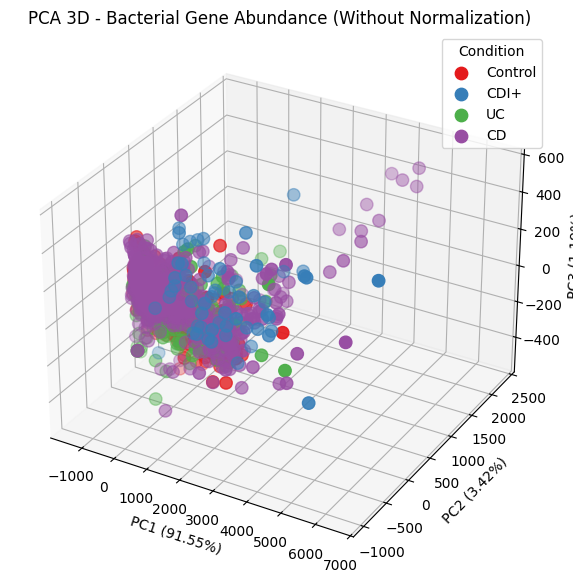

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# 📌 1. Load the data
df = complete_df.copy()

# 📌 2. Separate metadata (sample and condition)
samples = df["Individual"]
conditions = df["Condition"]  # For coloring the plot
df = df.drop(columns=["Individual", "Condition"])  # Keep only gene columns

# 📌 3. Apply PCA for 3 principal components
pca = PCA(n_components=3)  # Now we reduce to 3 components
pca_result = pca.fit_transform(df)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2", "PC3"])
pca_df["Individual"] = samples
pca_df["Condition"] = conditions

# 📌 4. Create a 3D PCA plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Map colors to conditions
colors = sns.color_palette("Set1", n_colors=len(pca_df["Condition"].unique()))
color_dict = {cond: color for cond, color in zip(pca_df["Condition"].unique(), colors)}

# Plot the points
for cond in pca_df["Condition"].unique():
    subset = pca_df[pca_df["Condition"] == cond]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"],
               label=cond, color=color_dict[cond], s=80)

ax.set_title("PCA 3D - Bacterial Gene Abundance (Without Normalization)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
ax.legend(title="Condition")

# 📌 5. Show plot
plt.show()


Repeating CDI+ machine-learning, since it shows higher divergence to control. It was only used Random Forest and XGBoost cause they are less sensitive to unbalanced data.

In [47]:
df_cdi = complete_df[complete_df['Condition'].isin(['CDI+', 'Control'])]

In [48]:
dfx = df_cdi.drop(['Condition', 'Individual'], axis=1)
dfy = df_cdi['Condition']
dfx_train, dfx_test, dfy_train, dfy_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)


In [49]:
from sklearn.ensemble import RandomForestClassifier  # For classification
from sklearn.metrics import roc_auc_score


# Create the model:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  # For classification

# Train the model:
model.fit(dfx_train, dfy_train)
ypred = model.predict(dfx_test)
accuracy = accuracy_score(dfy_test, ypred)

# Get the predicted probabilities for the positive class (usually class 1)
yprob = model.predict_proba(dfx_test)[:, 1]

# Calculate the AUC
auc = roc_auc_score(dfy_test, yprob)

print(f"AUC: {auc:.4f}")
print(f"accuracy: {accuracy:.4f}")

AUC: 0.9891
accuracy: 0.9725


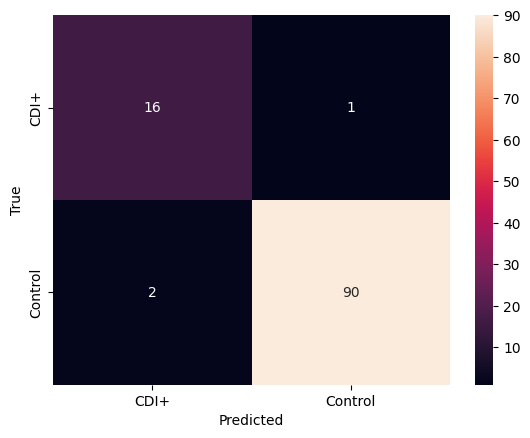

In [50]:
# Calculate the confusion matrix
cm = confusion_matrix(dfy_test,ypred)
# Obter os nomes das classes
class_names = sorted(dfy_test.unique())  # Para garantir que as classes estão ordenadas corretamente

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dfy_train_encoded = label_encoder.fit_transform(dfy_train)
dfy_test_encoded = label_encoder.transform(dfy_test)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, learning_rate=0.1 )
xgb_model.fit(dfx_train, dfy_train_encoded)
ypred_xgb = xgb_model.predict(dfx_test)
accuracy_score(dfy_test_encoded, ypred_xgb)


0.9724770642201835

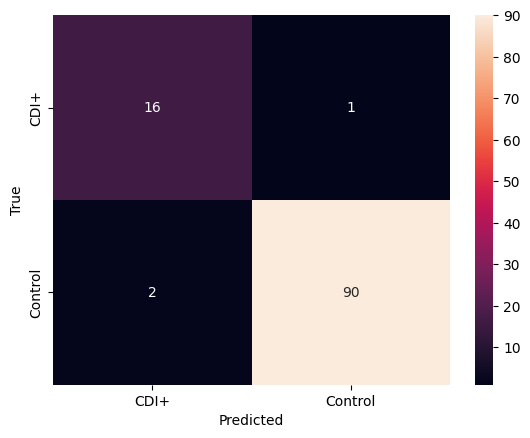

In [25]:
# Calculate the confusion matrix
cm = confusion_matrix(dfy_test_encoded,ypred_xgb)
# Obter os nomes das classes
class_names = sorted(dfy_test.unique())  # Para garantir que as classes estão ordenadas corretamente

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

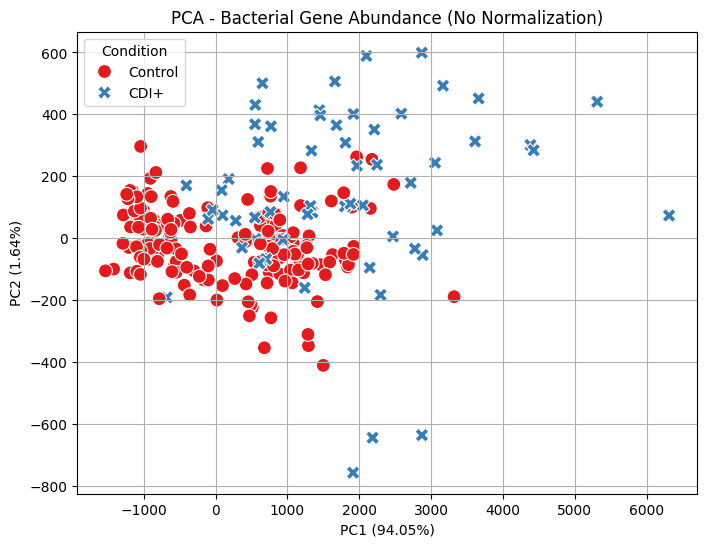

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 📌 1. Load the data
df = df_cdi

# 📌 2. Separate metadata (sample and condition)
samples = df["Individual"]
conditions = df["Condition"]  # To color the plot
df = df.drop(columns=["Individual", "Condition"])  # Only genes

# 📌 3. Apply PCA directly on the data without normalization
pca = PCA(n_components=2)  # Reduce to 2 principal components
pca_result = pca.fit_transform(df)

# Create DataFrame with principal components
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
pca_df["Individual"] = samples
pca_df["Condition"] = conditions

# 📌 4. Create PCA plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Condition", style="Condition", s=100, palette="Set1")
plt.title("PCA - Bacterial Gene Abundance (No Normalization)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Condition")
plt.grid()

# 📌 5. Show plot
plt.show()


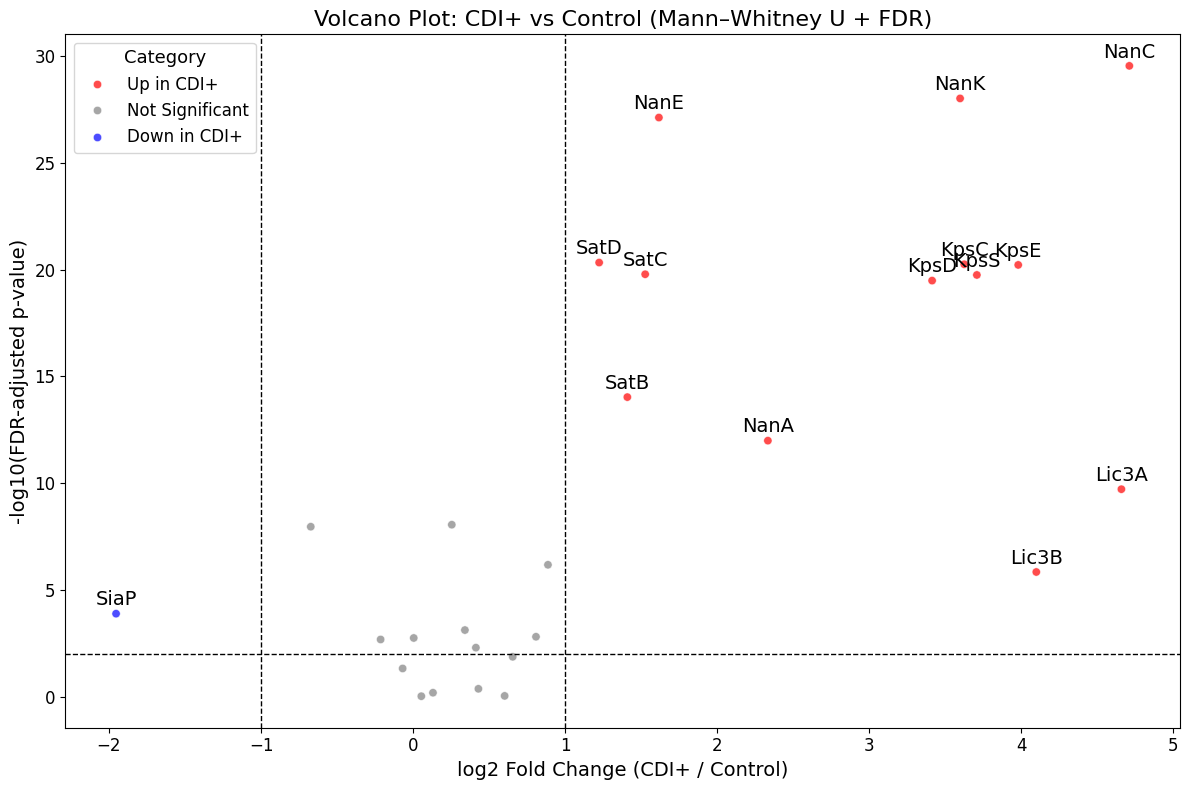

In [27]:
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only CDI+ and Control
data = complete_df[complete_df["Condition"].isin(["CDI+", "Control"])].copy()

# Identify genes (numeric columns)
genes = data.columns.difference(["Individual", "Condition"])

results = []

# Run Mann–Whitney U test for each gene
for gene in genes:
    cdi_vals = data[data["Condition"] == "CDI+"][gene].dropna()
    ctrl_vals = data[data["Condition"] == "Control"][gene].dropna()

    # If both groups have data and are not identical
    if len(cdi_vals) > 0 and len(ctrl_vals) > 0 and not (
        cdi_vals.nunique() <= 1 and ctrl_vals.nunique() <= 1
    ):
        stat, p = mannwhitneyu(cdi_vals, ctrl_vals, alternative="two-sided")

        # Log2 Fold Change
        mean_cdi = cdi_vals.mean()
        mean_ctrl = ctrl_vals.mean()
        log2fc = np.log2((mean_cdi + 1e-9) / (mean_ctrl + 1e-9))  # add small constant to avoid div by zero

        results.append((gene, stat, p, log2fc))

# Convert to DataFrame
p_values = pd.DataFrame(results, columns=["Gene", "U-statistic", "p-value", "log2FC"])

# FDR adjustment (Benjamini-Hochberg)
p_values = p_values.sort_values("p-value").reset_index(drop=True)
p_values["Rank"] = p_values.index + 1
p_values["FDR-adjusted p-value"] = p_values["p-value"] * len(p_values) / p_values["Rank"]
p_values["FDR-adjusted p-value"] = p_values["FDR-adjusted p-value"].clip(upper=1.0)
p_values["Significant"] = p_values["FDR-adjusted p-value"] < 0.01
p_values["-log10(FDR p-value)"] = -np.log10(p_values["FDR-adjusted p-value"])

# Classification function
def classify(row):
    if row["Significant"]:
        if row["log2FC"] > 1:
            return "Up in CDI+"
        elif row["log2FC"] < -1:
            return "Down in CDI+"
    return "Not Significant"

p_values["Category"] = p_values.apply(classify, axis=1)

# === VOLCANO PLOT ===
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=p_values,
    x="log2FC",
    y="-log10(FDR p-value)",
    hue="Category",
    palette={"Up in CDI+": "red", "Down in CDI+": "blue", "Not Significant": "gray"},
    alpha=0.7
)

# Threshold lines
plt.axhline(-np.log10(0.01), color="black", linestyle="--", lw=1)
plt.axvline(1, color="black", linestyle="--", lw=1)
plt.axvline(-1, color="black", linestyle="--", lw=1)

# Annotate significant genes with larger font
for _, row in p_values.iterrows():
    if row["Significant"] and abs(row["log2FC"]) > 1:
        plt.text(
            row["log2FC"],
            row["-log10(FDR p-value)"] + 0.2,  # offset upward
            row["Gene"],
            fontsize=14,
            ha="center",
            va="bottom"
        )

# Axes and title
plt.title("Volcano Plot: CDI+ vs Control (Mann–Whitney U + FDR)", fontsize=16)
plt.xlabel("log2 Fold Change (CDI+ / Control)", fontsize=14)
plt.ylabel("-log10(FDR-adjusted p-value)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Category", loc="upper left", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()
